## ISMT S-136 Time Series Analysis with Python, Summer 2021   
### Section 11

### Part I: Example of Recurrent Neural Networks (RNN) built with Keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, pacf

from pandas import DataFrame
from pandas import concat

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.layers import LSTM
from keras.layers import Dropout

### Simple Recurrent Neural Network (RNN)

In [2]:
n_features = 2
n_timesteps = 200

model = models.Sequential()
model.add(layers.SimpleRNN(16, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(layers.Dense(1, activation='linear')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 16)                304       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


### Long Short-Term Memory (LSTM)

In [3]:
n_features = 2
n_timesteps = 200

model = models.Sequential()
model.add(LSTM(16, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(layers.Dense(1, activation='linear')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1216      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


### Gated Recurrent Unit (GRU)

In [4]:
n_features = 2
n_timesteps = 200

model = models.Sequential()
model.add(layers.GRU(16, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(layers.Dense(1, activation='linear')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16)                912       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


### Part II:  Time Series Forecasting via RNN

#### (a) Generating Time Series:
Let's generate a time series with non-linear $E[x_t|x_{t-1},x_{t-2},\ldots]$:

In [5]:
def ts_simulate(phi,phi_interaction,omega,alpha,beta,n=100):
    
    n0 = 200
    n = n0 + n
    
    m = len(phi)
    p = len(alpha)
    q = len(beta)
        
    sigma = np.zeros(n)
    rt = np.zeros(n)
    xt = np.zeros(n)
    epsilon = np.random.normal(0, 1, n)
    
    for t in range(np.max([m, p, q])):
        sigma[t] = np.random.normal(0, 1)
        rt[t] = sigma[t] * epsilon[t]
        xt[t] = rt[t]
        
    for t in range(np.max([m, p, q]), n):
        term1 = omega + sum([alpha[i] * rt[t-1-i]**2 for i in range(p)])
        term2 = sum([beta[i] * sigma[t-1-i]**2 for i in range(q)])
        sigma[t] = np.sqrt(term1 + term2)
        rt[t] = sigma[t] * epsilon[t]
        xt[t] = phi[0] * xt[t-1] + phi[1] * xt[t-2] + phi_interaction * xt[t-1] * xt[t-2]  + rt[t]
        
    return xt[n0:]

(0.2, 0.86)

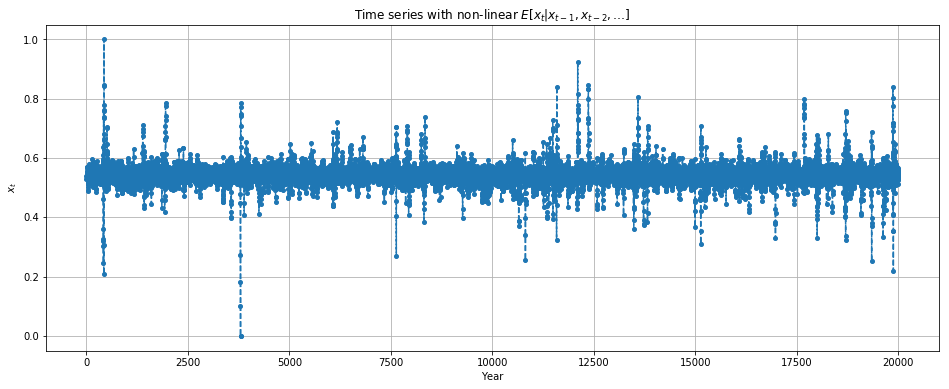

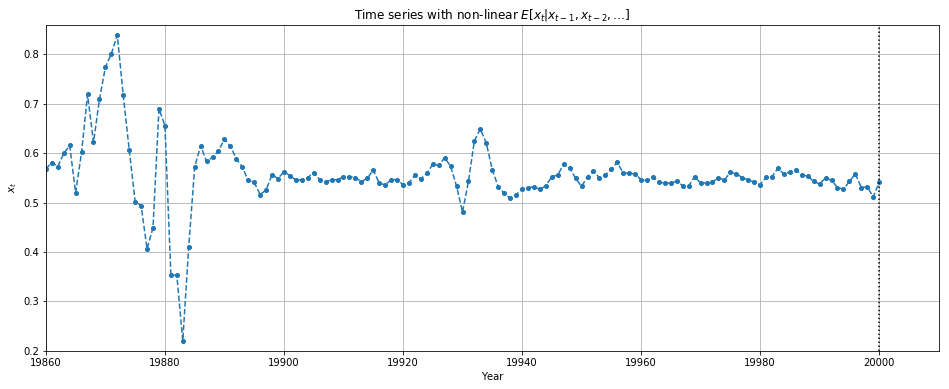

In [6]:
np.random.seed(54323)
phi = np.array([0.9,-0.2])
phi_interaction = 0.02
omega = 0.01
alpha = np.array([0.3, 0.6])
beta = np.array([0])

p_ar = 0 if ((len(phi)==1) & (phi[0]==0)) else len(phi)
p_garch = 0 if ((len(alpha)==1) & (alpha[0]==0)) else len(alpha)
q_garch = 0 if ((len(beta)==1) & (beta[0]==0)) else len(beta)

n = 20000
xt = ts_simulate(phi,phi_interaction,omega,alpha,beta,n)
xt = (xt-xt.min())/(xt.max()-xt.min())

plt.figure(figsize=(16,6))
plt.plot(xt, linestyle='--', marker='o', markersize=4)
plt.xlabel("Year")
plt.ylabel("$x_t$")
plt.title("Time series with non-linear $E[x_t|x_{t-1},x_{t-2},\ldots]$")
plt.grid(True)  

plt.figure(figsize=(16,6))
plt.plot(range(1,n+1),xt, linestyle='--', marker='o', markersize=4)
plt.xlabel("Year")
plt.ylabel("$x_t$")
plt.title("Time series with non-linear $E[x_t|x_{t-1},x_{t-2},\ldots]$")
plt.axvline(x=n,linestyle=':',color='k')
plt.grid(True)
plt.xlim(n-140,n+10)
plt.ylim(0.2,0.86)

#### (b) Preparing data for RNNs:

In [7]:
n_timesteps = 14

features_set = []
labels = []
for i in range(n_timesteps, xt.shape[0]):
    features_set.append(xt[i-n_timesteps:i])
    labels.append(xt[i])
    
features_set, labels = np.array(features_set), np.array(labels)
features_set = np.reshape(features_set,(features_set.shape[0], features_set.shape[1], 1))

#inputs: A 3D tensor with shape [batch, timesteps, feature]

In [8]:
print("features_set.shape is ", features_set.shape)
print("labels.shape is ", labels.shape)

features_set.shape is  (19986, 14, 1)
labels.shape is  (19986,)


In [9]:
# split into train and test sets
n = features_set.shape[0]
n_train = int(n * 0.80)
n_test = n - n_train
#print("n_train = ",str(n_train))
#print("n_test = ",str(n_test))

features_set_train, features_set_test =  features_set[0:n_train,:,:], features_set[n_train:n,:,:]
labels_train, labels_test =  labels[0:n_train], labels[n_train:n]

print("features_set_train.shape is ", features_set_train.shape)
print("labels_train.shape is ", labels_train.shape)
print("\nfeatures_set_test.shape is ", features_set_test.shape)
print("labels_test.shape is ", labels_test.shape)

features_set_train.shape is  (15988, 14, 1)
labels_train.shape is  (15988,)

features_set_test.shape is  (3998, 14, 1)
labels_test.shape is  (3998,)


In [10]:
print("2 first features:")
display(features_set_train[0:2,:,0])
print("2 first labels:")
display(labels_train[0:2])

2 first features:


array([[0.52886072, 0.53879605, 0.53447961, 0.55011176, 0.5426557 ,
        0.54990175, 0.53182389, 0.53446268, 0.53863755, 0.54352221,
        0.54630344, 0.5483666 , 0.55085239, 0.54680047],
       [0.53879605, 0.53447961, 0.55011176, 0.5426557 , 0.54990175,
        0.53182389, 0.53446268, 0.53863755, 0.54352221, 0.54630344,
        0.5483666 , 0.55085239, 0.54680047, 0.55622975]])

2 first labels:


array([0.55622975, 0.56948929])

#### (c) Time Series Forecasting via Simple RNN with 6 Recurrent Neurons

In [11]:
n_features = 1

model = models.Sequential()
model.add(layers.SimpleRNN(6, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(layers.Dense(1, activation='linear')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 6)                 48        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [12]:
nepochs = 40
model.compile(optimizer='adam',
              loss='mse')
history = model.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=32,
          validation_data=(features_set_test, labels_test))
history_rnn = history.history

Train on 15988 samples, validate on 3998 samples
Epoch 1/40
15988/15988 [==============================] - 4s 270us/step - loss: 9.6247e-04 - val_loss: 8.5589e-04
Epoch 2/40
15988/15988 [==============================] - 5s 296us/step - loss: 6.0140e-04 - val_loss: 6.5132e-04
Epoch 3/40
15988/15988 [==============================] - 5s 295us/step - loss: 4.7535e-04 - val_loss: 5.4453e-04
Epoch 4/40
15988/15988 [==============================] - 5s 294us/step - loss: 4.1670e-04 - val_loss: 4.8440e-04
Epoch 5/40
15988/15988 [==============================] - 5s 293us/step - loss: 3.8456e-04 - val_loss: 4.6515e-04
Epoch 6/40
15988/15988 [==============================] - 5s 295us/step - loss: 3.6250e-04 - val_loss: 4.4225e-04
Epoch 7/40
15988/15988 [==============================] - 5s 300us/step - loss: 3.5062e-04 - val_loss: 4.2710e-04
Epoch 8/40
15988/15988 [==============================] - 5s 300us/step - loss: 3.4087e-04 - val_loss: 4.4684e-04
Epoch 9/40
15988/15988 [===============

<Figure size 432x288 with 0 Axes>

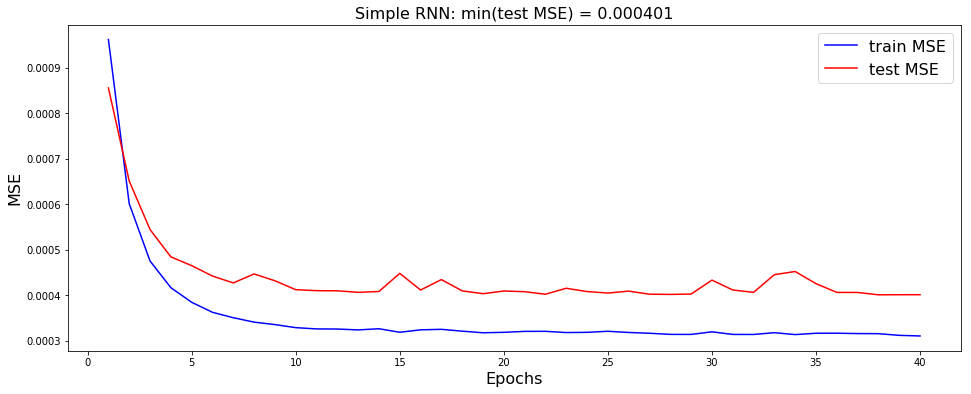

In [13]:
plt.clf()   # clear figure
train_mse = history_rnn['loss']
test_mse = history_rnn['val_loss']

plt.figure(figsize=(16,6))
plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")

plt.title('Simple RNN: min(test MSE) = ' + str(round(min(test_mse),6)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
#plt.ylim(0,0.001)

plt.show()

In [14]:
xt.shape

(20000,)

In [15]:
features_set.shape

(19986, 14, 1)

In [16]:
xhat = model.predict(features_set)
xhat

array([[0.54486775],
       [0.5542804 ],
       [0.5647361 ],
       ...,
       [0.5285482 ],
       [0.53505504],
       [0.51499915]], dtype=float32)

In [17]:
xhat.shape

(19986, 1)

In [18]:
len(xt)

20000

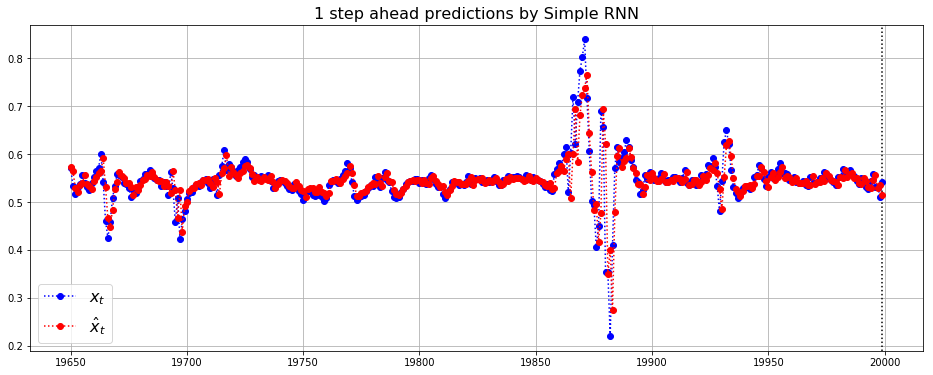

In [19]:
window = np.arange(len(xt)-350,len(xt))

plt.figure(figsize=(16,6))
plt.title("1 step ahead predictions by Simple RNN",fontsize=16)

plt.axvline(x=len(xt)-1,linestyle=':',color='k')
plt.plot(window,xt[window], linestyle=':', marker='o',color='blue',label = "$x_t$")
plt.plot(window,xhat[window-n_timesteps], linestyle=':', marker='o',color='red',label = "$\hat{x}_t$")

plt.grid(True)
plt.legend(loc = 'lower left',fontsize=16)
plt.show()

#### (d) Time Series Forecasting via LSTM

In [20]:
n_features = 1

model_lstm = models.Sequential()
model_lstm.add(LSTM(6, return_sequences=False, activation='tanh', input_shape=(n_timesteps,n_features)))
model_lstm.add(Dropout(0.2))
model_lstm.add(layers.Dense(1, activation='linear')) 

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 6)                 192       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [21]:
nepochs = 40
model_lstm.compile(optimizer='adam',
              loss='mse')
history = model_lstm.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=32,
          validation_data=(features_set_test, labels_test))
history_lstm = history.history

Train on 15988 samples, validate on 3998 samples
Epoch 1/40
15988/15988 [==============================] - 9s 579us/step - loss: 0.0248 - val_loss: 0.0010
Epoch 2/40
15988/15988 [==============================] - 8s 489us/step - loss: 0.0071 - val_loss: 9.8058e-04
Epoch 3/40
15988/15988 [==============================] - 8s 486us/step - loss: 0.0044 - val_loss: 8.5392e-04
Epoch 4/40
15988/15988 [==============================] - 8s 482us/step - loss: 0.0026 - val_loss: 9.4892e-04
Epoch 5/40
15988/15988 [==============================] - 8s 473us/step - loss: 0.0015 - val_loss: 8.5883e-04
Epoch 6/40
15988/15988 [==============================] - 8s 484us/step - loss: 0.0010 - val_loss: 8.7793e-04
Epoch 7/40
15988/15988 [==============================] - 8s 487us/step - loss: 8.0649e-04 - val_loss: 8.7650e-04
Epoch 8/40
15988/15988 [==============================] - 7s 454us/step - loss: 7.3656e-04 - val_loss: 8.6095e-04
Epoch 9/40
15988/15988 [==============================] - 7s 461us/

<Figure size 432x288 with 0 Axes>

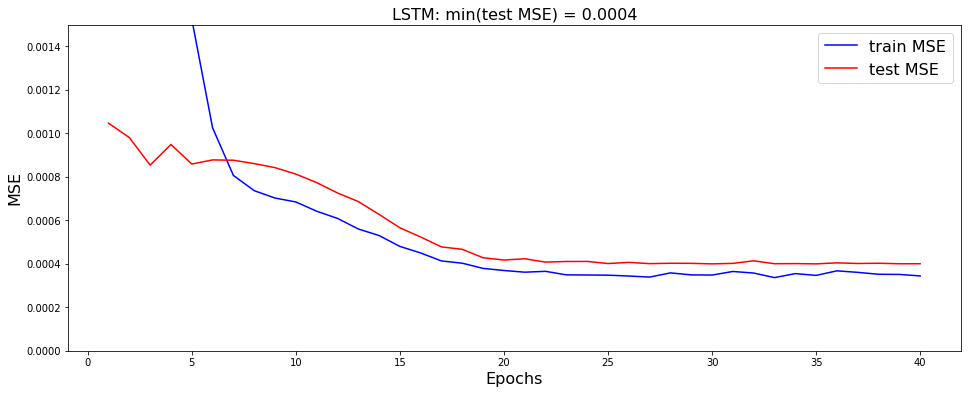

In [22]:
plt.clf()   # clear figure
train_mse = history_lstm['loss']
test_mse = history_lstm['val_loss']

plt.figure(figsize=(16,6))
plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")

#plt.ylim((0, 0.0001))
plt.title('LSTM: min(test MSE) = ' + str(round(min(test_mse),6)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
plt.ylim(0,0.0015)

plt.show()

In [23]:
xt.shape

(20000,)

In [24]:
features_set.shape

(19986, 14, 1)

In [25]:
xhat = model_lstm.predict(features_set)
xhat

array([[0.5442817 ],
       [0.553109  ],
       [0.56272155],
       ...,
       [0.5289908 ],
       [0.53549594],
       [0.51673204]], dtype=float32)

In [26]:
xhat.shape

(19986, 1)

In [27]:
len(xt)

20000

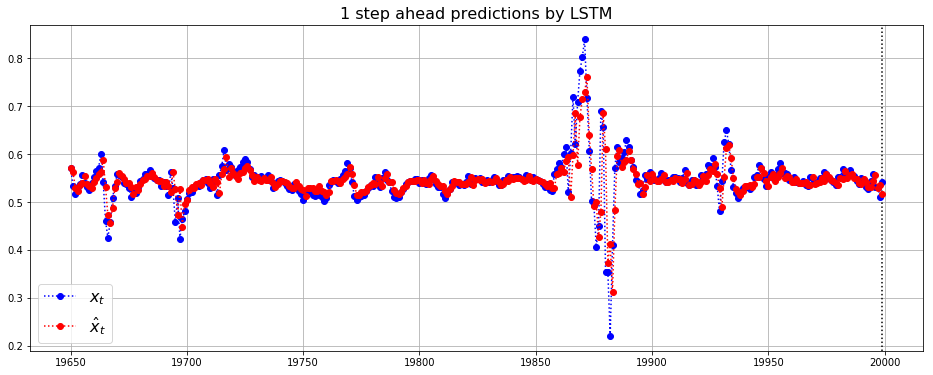

In [28]:
window = np.arange(len(xt)-350,len(xt))

plt.figure(figsize=(16,6))
plt.title("1 step ahead predictions by LSTM",fontsize=16)

plt.axvline(x=len(xt)-1,linestyle=':',color='k')
plt.plot(window,xt[window], linestyle=':', marker='o',color='blue',label = "$x_t$")
plt.plot(window,xhat[window-n_timesteps], linestyle=':', marker='o',color='red',label = "$\hat{x}_t$")

plt.grid(True)
plt.legend(loc = 'lower left',fontsize=16)
plt.show()

#### (e) Time Series Forecasting via GRU

In [29]:
n_features = 1

model_gru = models.Sequential()
model_gru.add(layers.GRU(6, return_sequences=False, activation='tanh', input_shape=(n_timesteps,n_features)))
model_gru.add(Dropout(0.2))
model_gru.add(layers.Dense(1, activation='linear')) 

model_gru.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 6)                 144       
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 7         
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [30]:
nepochs = 40
model_gru.compile(optimizer='adam',
              loss='mse')
history = model_gru.fit(features_set_train, labels_train,
          epochs=nepochs,
          batch_size=32,
          validation_data=(features_set_test, labels_test))
history_gru = history.history

Train on 15988 samples, validate on 3998 samples
Epoch 1/40
15988/15988 [==============================] - 11s 678us/step - loss: 0.0161 - val_loss: 9.9385e-04
Epoch 2/40
15988/15988 [==============================] - 10s 615us/step - loss: 0.0058 - val_loss: 7.1927e-04
Epoch 3/40
15988/15988 [==============================] - 10s 617us/step - loss: 0.0027 - val_loss: 6.6023e-04
Epoch 4/40
15988/15988 [==============================] - 10s 616us/step - loss: 0.0013 - val_loss: 6.5162e-04
Epoch 5/40
15988/15988 [==============================] - 10s 606us/step - loss: 7.5260e-04 - val_loss: 6.3770e-04
Epoch 6/40
15988/15988 [==============================] - 10s 613us/step - loss: 5.5281e-04 - val_loss: 6.0949e-04
Epoch 7/40
15988/15988 [==============================] - 10s 605us/step - loss: 4.8930e-04 - val_loss: 5.7329e-04
Epoch 8/40
15988/15988 [==============================] - 10s 613us/step - loss: 4.6416e-04 - val_loss: 5.2833e-04
Epoch 9/40
15988/15988 [=======================

<Figure size 432x288 with 0 Axes>

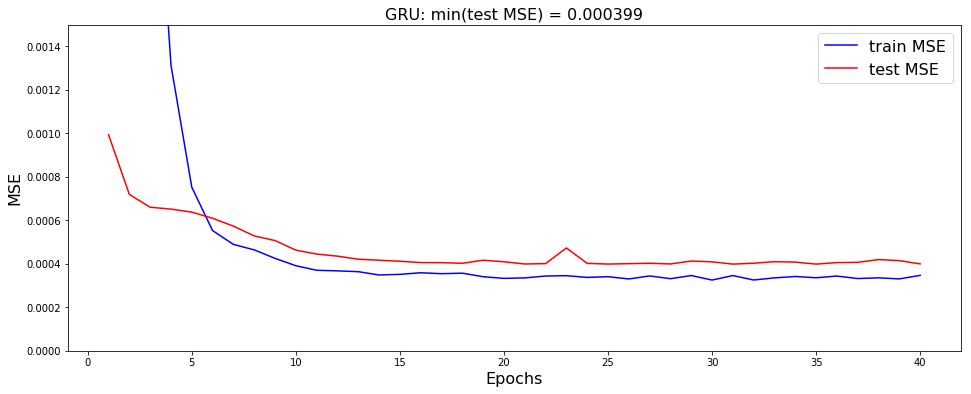

In [31]:
plt.clf()   # clear figure
train_mse = history_gru['loss']
test_mse = history_gru['val_loss']

plt.figure(figsize=(16,6))
plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
plt.plot(range(1,nepochs+1), test_mse, 'b', label='test MSE',color="red")

#plt.ylim((0, 0.0001))
plt.title('GRU: min(test MSE) = ' + str(round(min(test_mse),6)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
plt.ylim(0,0.0015)

plt.show()

In [32]:
xhat = model_lstm.predict(features_set)
xhat

array([[0.5442817 ],
       [0.553109  ],
       [0.56272155],
       ...,
       [0.5289908 ],
       [0.53549594],
       [0.51673204]], dtype=float32)

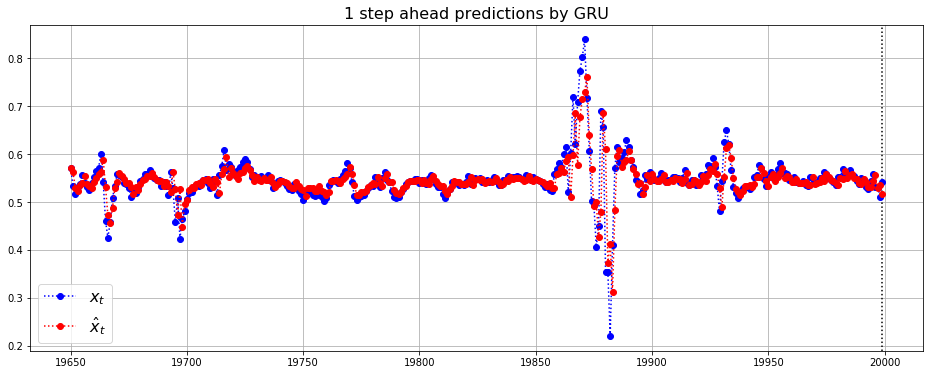

In [33]:
window = np.arange(len(xt)-350,len(xt))

plt.figure(figsize=(16,6))
plt.title("1 step ahead predictions by GRU",fontsize=16)

plt.axvline(x=len(xt)-1,linestyle=':',color='k')
plt.plot(window,xt[window], linestyle=':', marker='o',color='blue',label = "$x_t$")
plt.plot(window,xhat[window-n_timesteps], linestyle=':', marker='o',color='red',label = "$\hat{x}_t$")

plt.grid(True)
plt.legend(loc = 'lower left',fontsize=16)
plt.show()

#### (f) Test MSE Comparison: Simple RNN, LSTM, and RNN

(0, 0.0015)

<Figure size 432x288 with 0 Axes>

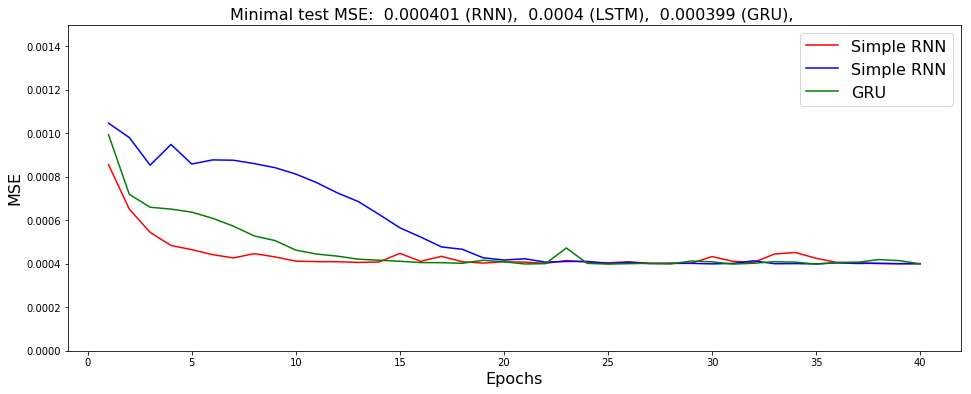

In [36]:
MSE_rnn = str(round(min(history_rnn['val_loss']),6))
MSE_lstm = str(round(min(history_lstm['val_loss']),6))
MSE_gru = str(round(min(history_gru['val_loss']),6))

plt.clf()   # clear figure

plt.figure(figsize=(16,6))
#plt.plot(range(1,nepochs+1), train_mse, 'b', label='train MSE',color="blue")
plt.plot(range(1,nepochs+1), history_rnn['val_loss'], 'b', label='Simple RNN',color="red")
plt.plot(range(1,nepochs+1), history_lstm['val_loss'], 'b', label='Simple RNN',color="blue")
plt.plot(range(1,nepochs+1), history_gru['val_loss'], 'b', label='GRU',color="green")

#plt.ylim((0, 0.0001))
plt.title('Minimal test MSE:  '
          + MSE_rnn + ' (RNN),  ' 
          + MSE_lstm + ' (LSTM),  '
          + MSE_gru + ' (GRU), ',
          fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
plt.ylim(0,0.0015)
